## Import modules

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing.image import load_img,img_to_array, array_to_img
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.utils import plot_model

## Set root directory of images and other parameters to control recommendations

In [2]:
imgs_path = "./data"
imgs_model_width, imgs_model_height = 224, 224
top_n_recos = 5 # number of most similar images to recommend

In [3]:
# Initialize the similarity dataframe
# ! Note: If we already trained the model once and just want to access predictions, run upto this cell and go for predictions cells directly
cos_similarities_df = None

## Model to identify the relevant features of images

In [4]:
# load the model
vgg_model = vgg16.VGG16(weights='imagenet')
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

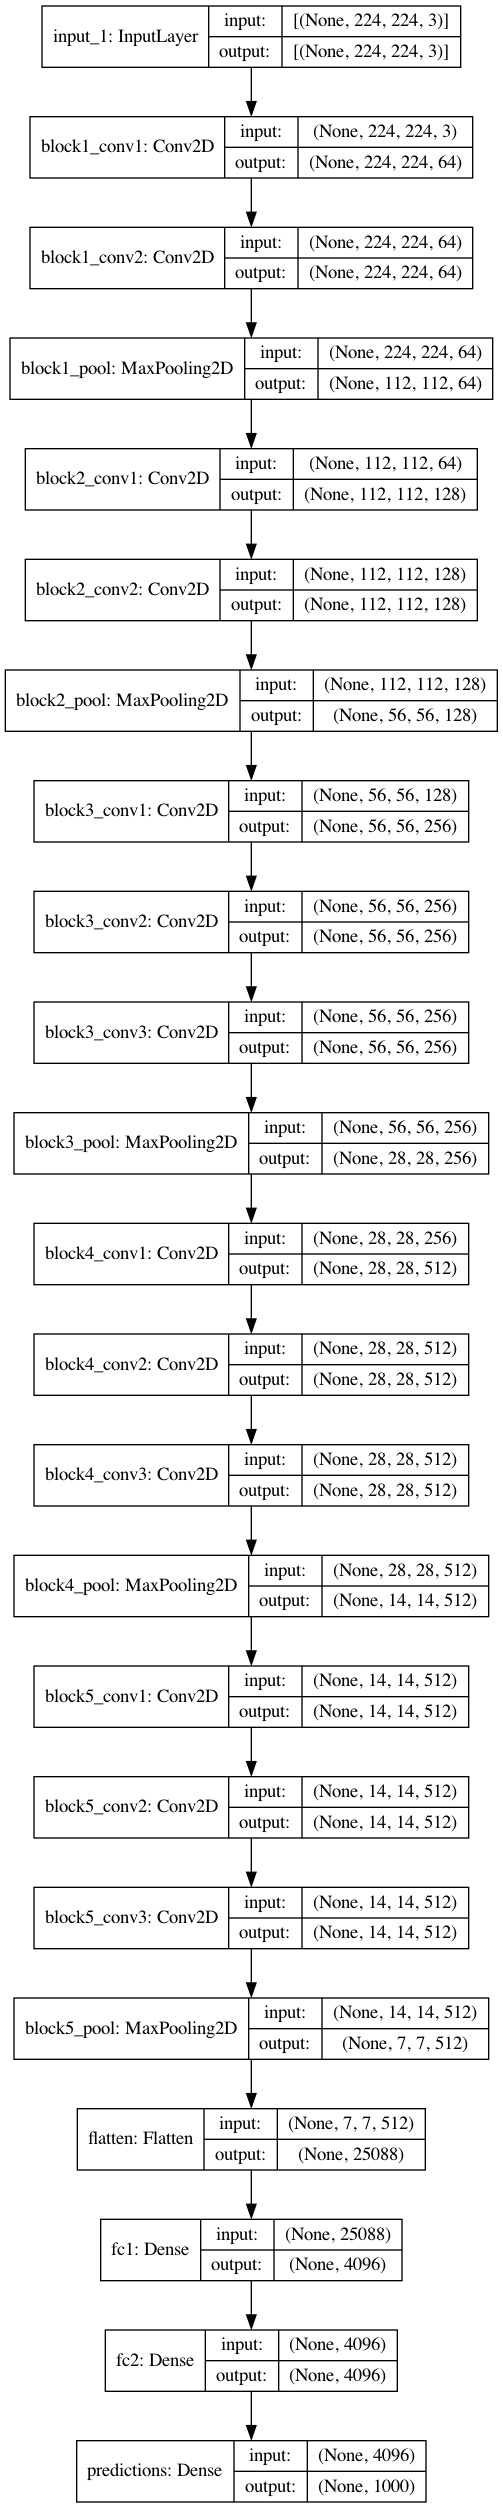

In [5]:
plot_model(vgg_model, "vgg_model.png", show_shapes=True)

In [6]:
# remove the last layers in order to get features
feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)
feat_extractor.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Index all the files in a list

In [7]:
files = []
for root, dirs, file_names in os.walk(imgs_path):
    for file in file_names:
        if(file.endswith(".jpg")): # TODO: Include other image formats - png, jpeg, etc
            files.append(os.path.join(root,file))

In [8]:
files

['./data/Footwear/Men/Images/images_with_product_ids/44770.jpg',
 './data/Footwear/Men/Images/images_with_product_ids/9055.jpg',
 './data/Footwear/Men/Images/images_with_product_ids/19311.jpg',
 './data/Footwear/Men/Images/images_with_product_ids/6414.jpg',
 './data/Footwear/Men/Images/images_with_product_ids/15517.jpg',
 './data/Footwear/Men/Images/images_with_product_ids/3550.jpg',
 './data/Footwear/Men/Images/images_with_product_ids/39943.jpg',
 './data/Footwear/Men/Images/images_with_product_ids/5690.jpg',
 './data/Footwear/Men/Images/images_with_product_ids/28655.jpg',
 './data/Footwear/Men/Images/images_with_product_ids/39980.jpg',
 './data/Footwear/Men/Images/images_with_product_ids/22191.jpg',
 './data/Footwear/Men/Images/images_with_product_ids/44572.jpg',
 './data/Footwear/Men/Images/images_with_product_ids/1637.jpg',
 './data/Footwear/Men/Images/images_with_product_ids/41436.jpg',
 './data/Footwear/Men/Images/images_with_product_ids/22152.jpg',
 './data/Footwear/Men/Images/i

## Load & Process image

### Below two cells are a sample to show the image processing in numpy and tensorflow

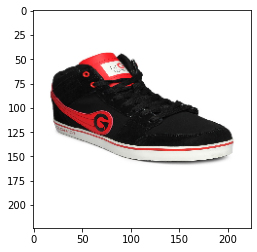

In [9]:
# load an image in PIL format
original = load_img(files[0], target_size=(imgs_model_width, imgs_model_height))
plt.imshow(original)
plt.show()

numpy image size:  (224, 224, 3)


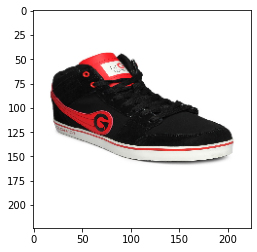

image batch size:  (1, 224, 224, 3)
processed image size: (1, 224, 224, 3)


In [10]:
# PIL format image - (width, height, channel)
# Numpy format image - (height, width, channel)
numpy_image = img_to_array(original)
print("numpy image size: ",numpy_image.shape)
plt.imshow(array_to_img(numpy_image))
plt.show()

# convert the image / images into batch format to pass into tensorflow model
image_batch = np.expand_dims(numpy_image, axis=0)
print('image batch size: ',image_batch.shape) # Batch size = 1

# Process the image for the VGG model
processed_image = preprocess_input(image_batch.copy())
print("processed image size:",processed_image.shape)

In [11]:
# load all the images and process them for feeding into the CNN
all_images = []
for f in files:
    original = load_img(f, target_size=(imgs_model_width, imgs_model_height))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)
    all_images.append(image_batch)
images = np.vstack(all_images)
processed_imgs = preprocess_input(images.copy())

In [12]:
imgs_features = feat_extractor.predict(processed_imgs)
print("features extracted from images by using pre-trained VGG16 keras model")
imgs_features.shape

features extracted from images by using pre-trained VGG16 keras model


(2906, 4096)

## Cosine Similarity between images / extracted features

In [13]:
# compute cosine similarities between images
cosine_similarities = cosine_similarity(imgs_features)
# Make the diagloanl score values '0' as we don't want the same image to be recommended
np.fill_diagonal(cosine_similarities, 0)
cos_similarities_df = pd.DataFrame(cosine_similarities, columns=files, index=files)
cos_similarities_df.head()

,./data/Footwear/Men/Images/images_with_product_ids/44770.jpg,./data/Footwear/Men/Images/images_with_product_ids/9055.jpg,./data/Footwear/Men/Images/images_with_product_ids/19311.jpg,./data/Footwear/Men/Images/images_with_product_ids/6414.jpg,./data/Footwear/Men/Images/images_with_product_ids/15517.jpg,./data/Footwear/Men/Images/images_with_product_ids/3550.jpg,./data/Footwear/Men/Images/images_with_product_ids/39943.jpg,./data/Footwear/Men/Images/images_with_product_ids/5690.jpg,./data/Footwear/Men/Images/images_with_product_ids/28655.jpg,./data/Footwear/Men/Images/images_with_product_ids/39980.jpg,...,./data/Apparel/Boys/Images/images_with_product_ids/3818.jpg,./data/Apparel/Boys/Images/images_with_product_ids/40137.jpg,./data/Apparel/Boys/Images/images_with_product_ids/31094.jpg,./data/Apparel/Boys/Images/images_with_product_ids/37220.jpg,./data/Apparel/Boys/Images/images_with_product_ids/34098.jpg,./data/Apparel/Boys/Images/images_with_product_ids/2694.jpg,./data/Apparel/Boys/Images/images_with_product_ids/36314.jpg,./data/Apparel/Boys/Images/images_with_product_ids/33278.jpg,./data/Apparel/Boys/Images/images_with_product_ids/21873.jpg,./data/Apparel/Boys/Images/images_with_product_ids/24937.jpg
./data/Footwear/Men/Images/images_with_product_ids/44770.jpg,0.000000,0.609515,0.681519,0.568297,0.633702,0.421349,0.598964,0.648762,0.668972,0.676242,...,0.256950,0.326352,0.343206,0.405365,0.480991,0.287075,0.333053,0.387553,0.318058,0.265630
./data/Footwear/Men/Images/images_with_product_ids/9055.jpg,0.609515,0.000000,0.723284,0.618196,0.643829,0.377727,0.492093,0.588798,0.691753,0.613406,...,0.184984,0.242212,0.264920,0.349274,0.446408,0.177217,0.276392,0.249322,0.214827,0.174281
./data/Footwear/Men/Images/images_with_product_ids/19311.jpg,0.681519,0.723284,0.000000,0.667147,0.670076,0.393650,0.564512,0.649002,0.720555,0.683027,...,0.227823,0.260462,0.296942,0.399871,0.457842,0.209559,0.348921,0.290014,0.227380,0.222274
./data/Footwear/Men/Images/images_with_product_ids/6414.jpg,0.568297,0.618196,0.667147,0.000000,0.617833,0.455571,0.673800,0.669415,0.657383,0.696059,...,0.202610,0.240796,0.293303,0.395512,0.451905,0.185400,0.266121,0.373150,0.238994,0.218998
./data/Footwear/Men/Images/images_with_product_ids/15517.jpg,0.633702,0.643829,0.670076,0.617833,0.000000,0.387723,0.612347,0.717978,0.714751,0.769793,...,0.178514,0.240673,0.229590,0.270574,0.357870,0.197250,0.220531,0.244969,0.223039,0.177288


In [14]:
cos_similarities_df.to_csv("model.csv")

## Prediction

In [15]:
def retrieve_most_similar_products(given_img, df):
    print("-"*50)
    print("original product:")
    original = load_img(given_img, target_size=(imgs_model_width, imgs_model_height))
    plt.imshow(original)
    plt.show()
    print("-"*50)
    print("most similar products:")
    closest_imgs = df[given_img].sort_values(ascending=False)[0:top_n_recos].index
    closest_imgs_scores = df[given_img].sort_values(ascending=False)[0:top_n_recos]
    for i in range(0,len(closest_imgs)):
        print(closest_imgs[i])
        original = load_img(closest_imgs[i], target_size=(imgs_model_width, imgs_model_height))
        plt.imshow(original)
        plt.show()
        print("similarity score : ",closest_imgs_scores[i])
        print("\n")

In [16]:
def load_data():
    df = pd.read_csv('model.csv')
    df.set_index("Unnamed: 0", inplace=True)
    return df

./data/Footwear/Men/Images/images_with_product_ids/44770.jpg
--------------------------------------------------
original product:


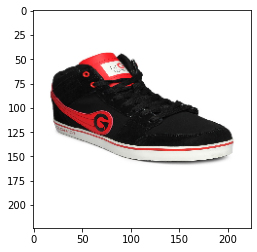

--------------------------------------------------
most similar products:
./data/Footwear/Men/Images/images_with_product_ids/13075.jpg


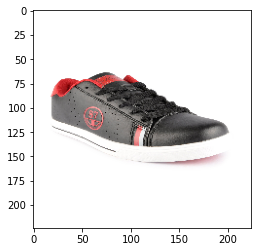

similarity score :  0.8394517


./data/Footwear/Men/Images/images_with_product_ids/11985.jpg


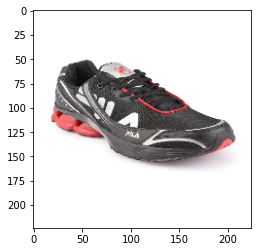

similarity score :  0.839355


./data/Footwear/Men/Images/images_with_product_ids/44776.jpg


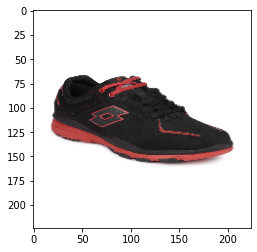

similarity score :  0.83791965


./data/Footwear/Men/Images/images_with_product_ids/41832.jpg


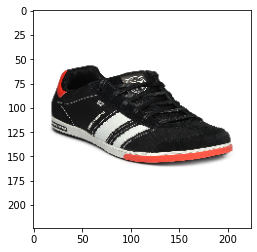

similarity score :  0.8302173


./data/Footwear/Men/Images/images_with_product_ids/44771.jpg


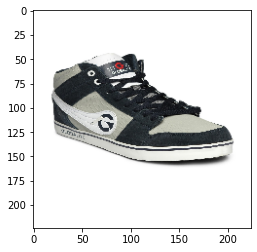

similarity score :  0.8270622




In [17]:
input_image_path = './data/Footwear/Men/Images/images_with_product_ids/44770.jpg'
print(input_image_path)
if input_image_path is not None:
    if cos_similarities_df is None:
        cos_similarities_df = load_data()
           
    retrieve_most_similar_products(input_image_path, cos_similarities_df)
else:
    print("Check the input path")

./data/Apparel/Girls/Images/images_with_product_ids/31128.jpg
--------------------------------------------------
original product:


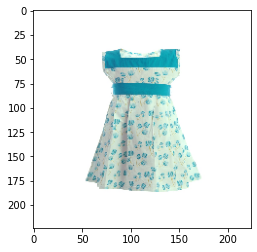

--------------------------------------------------
most similar products:
./data/Apparel/Girls/Images/images_with_product_ids/34064.jpg


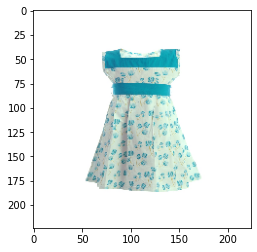

similarity score :  1.0


./data/Apparel/Girls/Images/images_with_product_ids/31129.jpg


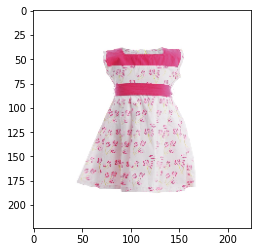

similarity score :  0.8752884


./data/Apparel/Girls/Images/images_with_product_ids/34061.jpg


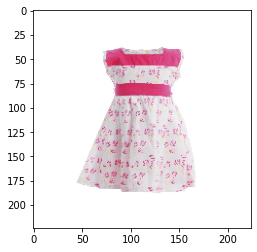

similarity score :  0.86901784


./data/Apparel/Girls/Images/images_with_product_ids/36752.jpg


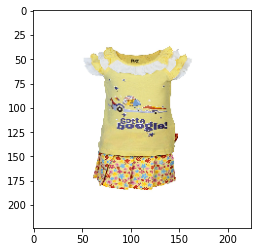

similarity score :  0.7443449


./data/Apparel/Girls/Images/images_with_product_ids/41972.jpg


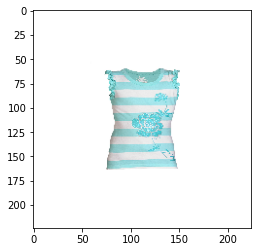

similarity score :  0.7380605




In [18]:
input_image_path = './data/Apparel/Girls/Images/images_with_product_ids/31128.jpg'
print(input_image_path)
if input_image_path is not None:
    if cos_similarities_df is None:
        cos_similarities_df = load_data()
           
    retrieve_most_similar_products(input_image_path, cos_similarities_df)
else:
    print("Check the input path")

./data/Apparel/Boys/Images/images_with_product_ids/34050.jpg
--------------------------------------------------
original product:


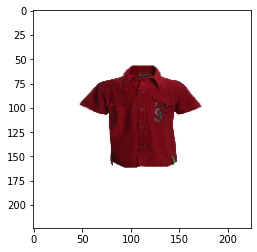

--------------------------------------------------
most similar products:
./data/Apparel/Boys/Images/images_with_product_ids/34051.jpg


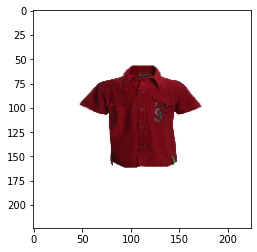

similarity score :  0.99999964


./data/Apparel/Boys/Images/images_with_product_ids/31092.jpg


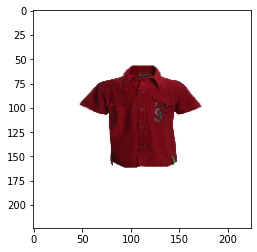

similarity score :  0.99999964


./data/Apparel/Boys/Images/images_with_product_ids/8336.jpg


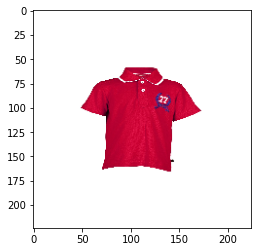

similarity score :  0.902034


./data/Apparel/Boys/Images/images_with_product_ids/8337.jpg


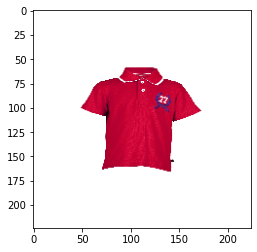

similarity score :  0.8973566


./data/Apparel/Boys/Images/images_with_product_ids/40947.jpg


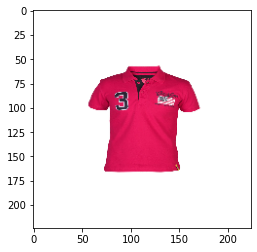

similarity score :  0.8424232




In [19]:
input_image_path = './data/Apparel/Boys/Images/images_with_product_ids/34050.jpg'
print(input_image_path)
if input_image_path is not None:
    if cos_similarities_df is None:
        cos_similarities_df = load_data()
           
    retrieve_most_similar_products(input_image_path, cos_similarities_df)
else:
    print("Check the input path")

./data/Apparel/Boys/Images/images_with_product_ids/33143.jpg
--------------------------------------------------
original product:


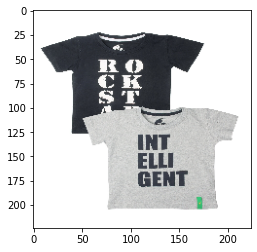

--------------------------------------------------
most similar products:
./data/Apparel/Boys/Images/images_with_product_ids/38953.jpg


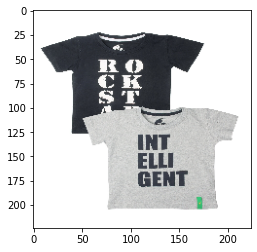

similarity score :  0.9999998


./data/Apparel/Boys/Images/images_with_product_ids/38952.jpg


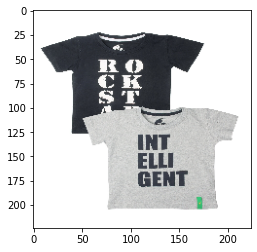

similarity score :  0.99999976


./data/Apparel/Boys/Images/images_with_product_ids/38490.jpg


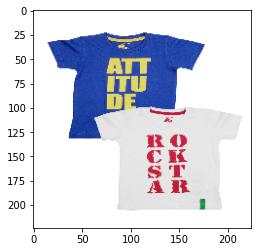

similarity score :  0.8956956


./data/Apparel/Boys/Images/images_with_product_ids/41011.jpg


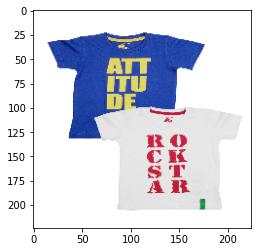

similarity score :  0.8956956


./data/Apparel/Boys/Images/images_with_product_ids/41012.jpg


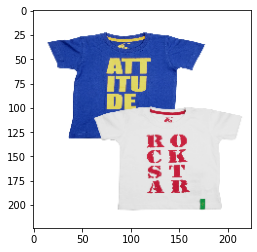

similarity score :  0.8932073




In [20]:
input_image_path = './data/Apparel/Boys/Images/images_with_product_ids/33143.jpg'
print(input_image_path)
if input_image_path is not None:
    if cos_similarities_df is None:
        cos_similarities_df = load_data()
           
    retrieve_most_similar_products(input_image_path, cos_similarities_df)
else:
    print("Check the input path")